In [0]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
np.set_printoptions(threshold=np.nan)

In [0]:
SPEED = 1.4
LENGTH = 1.5


In [0]:
class link:
    def __init__(self, inp_state, inp_index):
        self.state = inp_state
        self.index = inp_index
        

In [0]:
def rad_to_deg(delta):
    return delta * 180 / math.pi

In [0]:
def deg_to_rad(delta):
    return delta * math.pi/180

In [0]:
class state:

    def __init__(self, x, y, theta, g,f, steer):
        self.x = x
        self.y = y
        self.theta = theta
        self.g = g
        self.f = f
        self.steer = steer


In [0]:
def normalize(theta):
    if theta < 0:    
        theta = theta + 2.0 * math.pi
        return theta
    if theta > 2*np.pi:    
        theta = theta - 2.0 * math.pi
        return theta
    else:
        return theta 

In [0]:
def heuristic(x,y,goal):
    distance  = math.sqrt( ((x-goal.x)**2) + ((y-goal.y)**2) )
    return distance

In [0]:
def expand(v_state, goal):
    next_states = []
    for delta in range(-35, 40, 5): 
        # Create a trajectory with delta as the steering angle using the bicycle model:

        # ---Begin bicycle model---
        delta_rad = deg_to_rad(delta)
        omega = SPEED/LENGTH * delta_rad
        
        d_x = SPEED * math.cos(v_state.theta)
        d_y = SPEED * math.sin(v_state.theta)
        next_x = v_state.x + d_x
        next_y = v_state.y + d_y
        next_theta = normalize(v_state.theta + (omega))
        
        # ---End bicycle model-----
        next_g = v_state.g + np.sqrt( d_x * d_x +  d_y * d_y )
        next_f = next_g + heuristic(next_x, next_y, goal)

        # Create a new State object with all of the "next" values.
        new_state = state(next_x, next_y, next_theta, next_g, next_f)
        next_states.append(new_state)

    return next_states

In [0]:
def transition(v_state, delta, dt, goal):
   
    # ---Begin bicycle model---
    #delta_rad = deg_to_rad(delta)
    omega = SPEED/LENGTH * math.tan(delta)
    
    
    d_x = SPEED * math.cos(v_state.theta) * dt
    d_y = SPEED * math.sin(v_state.theta) * dt
    
    next_x = v_state.x + d_x
    next_y = v_state.y + d_y
    next_theta = normalize(v_state.theta + (omega*dt)) 

    # ---End bicycle model-----
    next_g = v_state.g + np.sqrt( d_x * d_x +  d_y * d_y )
    next_f = next_g+heuristic(next_x, next_y, goal)
    next_steer = delta

    # Create a new State object with all of the "next" values.
    new_state = state(next_x, next_y, next_theta, next_g, next_f, next_steer)

    return new_state

In [0]:
w = np.array([[1, 0],[-1,0]])

In [0]:
vehicle_points = np.array([[-1.1, 2],[0, 2],[1.1, 2],[-1.1, 0],[0, 0],[1.1,0],[-1.1, -2],[0, -2],[1.1, -2]])

In [0]:
def rotation(w,t):
    y = np.array([[math.cos(t), math.sin(t)], [-math.sin(t), math.cos(t)]])
    return np.matmul(w, y)
    

In [0]:
def transformation(w, x, y,t):
    p = np.zeros_like(w)
    for i in range(p.shape[0]):
        p[i][0:2] = w[i][0:2]+[x,y]
        
    return rotation(p,(t-np.pi/2))
    
    

In [0]:
transformation(vehicle_points, 1.0, 0.0, np.pi/2)

array([[-0.1,  2. ],
       [ 1. ,  2. ],
       [ 2.1,  2. ],
       [-0.1,  0. ],
       [ 1. ,  0. ],
       [ 2.1,  0. ],
       [-0.1, -2. ],
       [ 1. , -2. ],
       [ 2.1, -2. ]])

In [0]:
print(rotation(vehicle_points, deg_to_rad(-90)))

[[  2.00000000e+00   1.10000000e+00]
 [  2.00000000e+00   1.22464680e-16]
 [  2.00000000e+00  -1.10000000e+00]
 [ -6.73555740e-17   1.10000000e+00]
 [  0.00000000e+00   0.00000000e+00]
 [  6.73555740e-17  -1.10000000e+00]
 [ -2.00000000e+00   1.10000000e+00]
 [ -2.00000000e+00  -1.22464680e-16]
 [ -2.00000000e+00  -1.10000000e+00]]


In [0]:
grid_x_m = 20
grid_y_m = 20

coll_cell_side = 1
grid_coll_x = np.int( np.ceil(grid_x_m/coll_cell_side) )
grid_coll_y = np.int( np.ceil(grid_y_m/coll_cell_side) )

grid = np.zeros((grid_coll_x,grid_coll_y), np.int)

In [0]:
cell_side = 1.0
x_offset = (grid.shape[1]*coll_cell_side)/2
y_offset = 0.0


In [0]:
def get_grid_coordinates(x, y):
    x = x+x_offset
    y = y+y_offset
    cell_x = math.floor(x/cell_side)
    cell_y = math.floor(y/cell_side)
    #grid[cell_y, cell_x] = 2
    return cell_x, cell_y
    

In [0]:
def check_occupancy(x, y):
    x = x+x_offset
    y = y+y_offset
    cell_x = math.floor(x/coll_cell_side)
    cell_y = math.floor(y/coll_cell_side)
    #grid[cell_y, cell_x] = 2
    return grid[cell_y, cell_x]
    

In [0]:
def delta_t(delta, n, off):
    #delta = deg_to_rad(delta)#for convenient debugging
    #off = deg_to_rad(off)#for convenient debugging
    delta_list = []
    delta_list.append(delta)
    delta_calc = delta
    for i in range(0 ,n):
        delta_calc += off   
        if delta_calc < max_angle:
            delta_list.append(delta_calc)
        
    delta_calc = delta
    for i in range(0 ,n):
        delta_calc -= off
        if min_angle < delta_calc:
            delta_list.append(delta_calc)
        
    return delta_list

In [0]:
def checkLimits( x,y ):
    
    result = True
    
    if  ( x < -grid_x_m/2 ) | \
        ( y < 0 ) | \
        ( x > grid_x_m/2 ) | \
        ( y > grid_y_m ):
        
        result = False
    
    return result

In [0]:
max_angle = 0.785398
min_angle = -0.785398

In [0]:
def check_closed(x, y, theta):
    x = x + x_state_offset
    y = y + y_state_offset
    
    cell_x = math.floor(x/state_cell_side)
    cell_y = math.floor(y/state_cell_side)
    
    cell_theta = math.floor( theta * NUM_THETA_CELLS / (2.0 * np.pi) )
    return closed[cell_theta][cell_y][cell_x]
    

In [0]:
def set_closed(x, y, theta):
    x = x + x_state_offset
    y = y + y_state_offset
    
    cell_x = math.floor(x/state_cell_side)
    cell_y = math.floor(y/state_cell_side)
    
    cell_theta = math.floor( theta * NUM_THETA_CELLS / (2.0 * np.pi) )
    closed[cell_theta][cell_y][cell_x] = 1


In [0]:
state_cell_side = 1
grid_state_x = np.int( np.ceil(grid_x_m/state_cell_side) )
grid_state_y = np.int( np.ceil(grid_y_m/state_cell_side) )

NUM_THETA_CELLS = 360
closed = [[[0 for x in range(grid_state_x)] for y in range(grid_state_y)] for cell in range(NUM_THETA_CELLS)]

x_state_offset = grid_x_m/2.0
y_state_offset = 0.0


In [0]:
current_state = state(0.0, 2.1, np.pi/2, 0.0, 0.0, 0.0)
new_points = np.copy(vehicle_points)
#print(new_points)

Goal.x = 0.0
Goal.y = 18.0
    

In [0]:
#print(current_state.x, current_state.y, current_state.theta)

path_state = current_state
open_list = []
path_link = link( path_state, 0 )
open_list.append( path_link )

trace_list = []
trace_link = link( path_state, -1 )
trace_list.append( trace_link )


path_x = []
path_y = []

path_x.append( current_state.x )
path_y.append( current_state.y )




goal


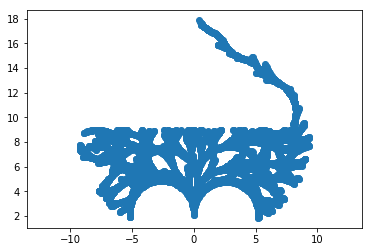

In [0]:
goal_reached = 0

for count in range(2):
    while ( len(open_list) > 0 ) & (goal_reached == 0):

        open_list.sort( key=lambda ste:ste.state.f )

        path_link = open_list.pop(0)
        path_state = path_link.state
        path_index = path_link.index

       # print( "" )
        #print( "Best path")
        #print( path_state.x, path_state.y, path_state.theta, path_state.f )
        path_x.append( path_state.x )
        path_y.append( path_state.y )


        #exit = 0

        #while exit == 0:

        delta_angle = delta_t( path_state.steer, 5, deg_to_rad(5.0) )
        delta_angle = [ 30 * np.pi / 180, 20 * np.pi / 180, 0, -20 * np.pi / 180, -30 * np.pi / 180 ]

        #print( delta_angle )

        state_list = []

        for i in range(len(delta_angle)):
            
            new_state = transition( path_state, delta_angle[i], 0.1, Goal)
            
            #print( new_state.x, new_state.y, new_state.theta )
            if check_closed( new_state.x, new_state.y, new_state.theta ) == 0:
                if checkLimits( new_state.x , new_state.y ) == True:
                    state_list.append(new_state)
                    set_closed( new_state.x, new_state.y, new_state.theta )
                    
                    #print( new_state.x, new_state.y, new_state.steer )

        collision_free = []

        for i in range(len(state_list)):

            check = 0
            #new_points = transformation(vehicle_points, state_list[i].x, state_list[i].y, state_list[i].theta)
            new_points = [ [ state_list[i].x, state_list[i].y ] ]
            
            for point in new_points :
                if checkLimits(point[0],point[1]) == True:

                    get_x, get_y = get_grid_coordinates(point[0], point[1])
                    
                    check = check_occupancy(point[0], point[1])
                   
                else :
                    check =1

                if check == 1:
                
                   break

            if check == 0:
                collision_free.append(state_list[i])
                

        if( collision_free ):

            for nstate in collision_free:
                
                #print( nstate.x, nstate.y, nstate.theta )
                new_link = link( nstate, len(trace_list) )
                open_list.append( new_link )
                
                trace_link = link( nstate, path_index )
                trace_list.append( trace_link )
                          
                
                if np.sqrt((nstate.x - Goal.x)**2 + (nstate.y - Goal.y)**2) < 0.5:
                    goal_reached = 1
                    path_x.append( nstate.x )
                    path_y.append( nstate.y )
                    print( "goal")
                    


            #path_state = collision_free[0]

            #if checkLimits( path_state ) == True:
            #    path_x.append( path_state.x )
            #    path_y.append( path_state.y )

                #print( path_state.x, path_state.y )


    #print( "" )
    #print( "Ostates")
    #for ostate in open_list:

       # print( ostate.x, ostate.y, ostate.theta, ostate.f )

plt.scatter( path_x, path_y )
plt.axis('equal')
plt.show()
        
    
#print(current_state.x, current_state.y, current_state.theta)
#print(new_points)
#grid_v = np.copy(grid)

#    if check == 1:
#        break

#if check == 0:
#    print(grid_v)

#print(grid_v)

#plt.scatter(px,py)


















#plt.show()

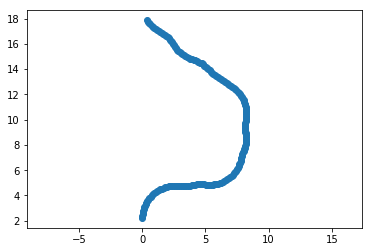

In [0]:
if goal_reached == 1 :
        fpath_x = []
        fpath_y = []
        
        curr_trace = trace_list[-1]
        
        while( curr_trace.index != -1 ):
            fpath_x.append( curr_trace.state.x )
            fpath_y.append( curr_trace.state.y )
            
            curr_trace = trace_list[ curr_trace.index ]
            
plt.scatter( fpath_x, fpath_y )
plt.axis( 'equal' )
plt.show()
    

In [0]:
print( math.floor( 6.277231820095903 * NUM_THETA_CELLS / np.pi ) )


719


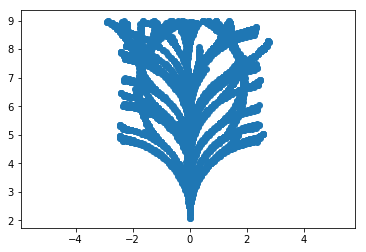

In [0]:
plt.scatter( path_x, path_y )
plt.axis('equal')
plt.show()

In [0]:
class start:

    def __init__(self, x, y, theta):
        self.x = x
        self.y = y
        self.theta = theta
        
class goal:

    def __init__(self, x, y):
        self.x = x
        self.y = y